# Regressionsanalys med interaktionseffekter
*av Anders Sundell*

Med regressionsanalys kan man undersöka samband mellan variabler, med eller utan kontroll för andra variabler. I verkligheten är det dock ofta så att samband ser olika ut i olika grupper, eller under olika omständigheter. Effekten av att bli förälder på arbetsinkomst är till exempel mycket olika för kvinnor och män; kvinnor ser en mycket större nedgång i inkomster.

Hur ska man ta hänsyn till detta i sina analyser? Ett sätt kan vara att göra två separata analyser, där man jämför kvinnor som fått barn med kvinnor som inte fått barn, och motsvarande för män. Men det går faktiskt att baka ihop det i en regressionsanalys. Vi kan då se hur effekten skiljer sig åt, och också om skillnaden i effekt är statistiskt signifikant. På så sätt kan vi se om det är värt att komplicera modellen ytterligare genom att införa dessa separata effekter. Vi håller också effekten av alla kontrollvariabler konstant. Gör man separata analyser kommer de också kunna få olika effekter i varje analys, och det är vi kanske inte intresserade av.

__Detta kallas för en interaktionsanalys. Det kan också kallas för en moderationsanalys, moderering, eller på engelska att man undersöker conditional effects. Poängen är oavsett att man låter effekten av en variabel variera över värdena på en annan variabel.__ Schematiskt brukar det representeras av ett diagram med en "pil på pilen" - dvs den tredje variabeln påverkar *effekten* av den oberoende variabeln, snarare än värdet på någon av de andra variablerna.

<img src = "../images/interaktionsdiagram.svg" alt="En interaktion" />

I det här inlägget kommer vi gå igenom hur man gör regressionsanalyser där både oberoende variabel och interaktionsvariabel bara har två värden, och hur man bäst ska presentera resultaten.

För att ha något att jobba med kommer vi i det här exemplet att använda oss av data från den amerikanska <a href="http://gss.norc.org/get-the-data/stata">General Social Survey</a>, som är en enkätundersökning med vanliga medborgare, med frågor om allt möjligt. Vi kommer använda versionen från 2016. Ladda ned den och lägg den i projektmappen för att följa med i exemplet. Jag har lagt den i en undermapp som heter data, och anger därför också det när jag öppnar filen.

In [60]:
cd "/Users/xsunde/Dropbox/Jupyter/stathelp"

/Users/xsunde/Dropbox/Jupyter/stathelp


In [61]:
use "data/GSS2016.dta", clear

## Förbereda datan för analys

Frågeställningen vi ska undersöka först är just den som nämndes ovan, hur barnafödande hänger ihop med inkomst för kvinnor och män. Egentligen undersöks en sådan frågeställning bäst med data över tid, där vi kan följa individer före och efter att de får barn. Eftersom det här är tvärsnittsdata och vi bara har data från en tidpunkt är inte det möjligt, och vi kommer därför bara att jämföra dem som har barn med dem som inte har det. Vi måste därför vara försiktiga med att dra slutsatser om orsak och verkan.

Vi behöver tre variabler: kön, inkomst, och antal barn. Kön finns beskrivet i variabeln __sex__, där 1 betyder "male" och 2 "female". För att det ska bli lättare att tolka resultaten framöver gör vi dock om variabeln, så att den får värdet 0 för män, och 1 för kvinnor. Dessutom döper vi om den till "woman" istället för sex. När vi ökar variabeln blir det alltså "mer kvinna".

In [62]:
recode sex (1=0) (2=1), generate(woman)

(2867 differences between sex and woman)


In [63]:
tab woman


  RECODE of |
        sex |
(respondent |
     s sex) |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,276       44.51       44.51
          1 |      1,591       55.49      100.00
------------+-----------------------------------
      Total |      2,867      100.00


Därefter behöver vi en variabel för inkomst. Det finns några olika att välja på, men den enklaste verkar vara __realrinc__, som beskriver respondentens inkomst i antal dollar per år. Vi ser nedan att medelvärdet är 23772.

In [6]:
sum realrinc


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
    realrinc |      1,632    23772.92    29407.37        234     164382


Slutligen behöver vi en variabel för barn. Det finns en sådan, som visar hur många barn respondenten har, __childs__:

In [7]:
tab childs


    number of |
     children |      Freq.     Percent        Cum.
--------------+-----------------------------------
            0 |        797       27.88       27.88
            1 |        459       16.05       43.93
            2 |        733       25.64       69.57
            3 |        467       16.33       85.90
            4 |        213        7.45       93.35
            5 |         92        3.22       96.57
            6 |         51        1.78       98.36
            7 |         25        0.87       99.23
eight or more |         22        0.77      100.00
--------------+-----------------------------------
        Total |      2,859      100.00


Dock är vi först bara intresserade av att jämföra dem som har barn med dem som inte har det. Troligtvis ser vi de största effekterna när man skaffar det första barnet, även om senare barn också kan påverka, men det återkommer vi till. Nu vill vi göra en ny dummyvariabel som är 0 om man har 0 barn, och 1 om man har 1 eller fler. Det blir en så kallad dummyvariabel, och vi kallar den __dum_kids__:

In [64]:
recode childs (0=0) (1/8 = 1), generate(dum_kids)

(1603 differences between childs and dum_kids)


In [47]:
tab dum_kids


  RECODE of |
     childs |
 (number of |
  children) |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        797       27.88       27.88
          1 |      2,062       72.12      100.00
------------+-----------------------------------
      Total |      2,859      100.00


Nu har vi alla variabler vi behöver för analysen. Vi kan börja med att göra en korrelationsmatris för att se hur de olika variablerna hänger ihop, och vi lägger där också till variabeln __age__, som visar respondentens ålder. Vi kommer att ha med den som kontrollvariabel.

In [65]:
pwcorr woman realrinc dum_kids age


             |    woman realrinc dum_kids      age
-------------+------------------------------------
       woman |   1.0000 
    realrinc |  -0.1628   1.0000 
    dum_kids |   0.1047   0.0821   1.0000 
         age |   0.0418   0.1332   0.3493   1.0000 


Korrelationen mellan kön och inkomst är negativ, och eftersom vi kommer ihåg att kvinna hade det högre värdet på woman-variabeln innebär det att kvinnor har lägre inkomster. Mer kvinna hänger ihop med mindre inkomst. Kvinna har också en positiv korrelation med att ha barn. Barn har i sin tur en positiv korrelation med inkomst - antagligen beroende på att de som har barn är äldre och har högre inkomster. Vi ser att ålder har ett positivt samband både med inkomst och att ha barn.

## Interaktionsanalys där interaktionsvariablerna bara har två värden

I den första analysen ska vi alltså se på hur att ha barn hänger ihop med inkomst, och sedan dela upp det på kvinnor och män. Men först gör vi en vanlig regressionsanalys, utan interaktion, där vi bara lägger in alla variablerna som de är. Beroende variabel är alltså inkomst.


In [49]:
reg realrinc woman dum_kids age 


      Source |       SS           df       MS      Number of obs   =     1,627
-------------+----------------------------------   F(3, 1623)      =     26.64
       Model |  6.5114e+10         3  2.1705e+10   Prob > F        =    0.0000
    Residual |  1.3225e+12     1,623   814854652   R-squared       =    0.0469
-------------+----------------------------------   Adj R-squared   =    0.0452
       Total |  1.3876e+12     1,626   853396969   Root MSE        =     28546

------------------------------------------------------------------------------
    realrinc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       woman |  -9748.911   1421.057    -6.86   0.000    -12536.21   -6961.612
    dum_kids |    3603.04   1636.325     2.20   0.028     393.5083    6812.571
         age |   241.0386   52.86283     4.56   0.000      137.352    344.7252
       _cons |   15430.49   2452.935     6.29   0.

Resultaten är som man kan förvänta sig. Koefficienten för __woman__ är -9748, vilket innebär att kvinnor i genomsnitt har 9748 dollar lägre årsinkomst än män, även med hänsyn taget till ålder och om man har barn eller ej.

Koefficienten för ålder är 241, vilket innebär att de som är ett år äldre i genomsnitt har 241 dollar mer i årsinkomst. Att vara man hänger alltså ihop med samma inkomstökning som att bli 9748/241=40 år äldre!

Och de som har barn har i genomsnitt 3603 dollar mer i årsinkomst. Vi kan dock se att signifikansvärdet är högre här än för de andra variablerna. Det finns alltså en lite större osäkerhet på om det verkligen handlar om ett riktigt samband som syns i hela befolkningen, och inte bara består på slump i urvalet. Men värdet är ändå lägre än den konventionella gränsen på 0.050.

Men effekten av barn antas här vara samma för både kvinnor och män, och vi ska nu undersöka om det är ett rimligt antagande. För att göra det behöver vi lägga till en så kallad interaktionsterm, en ny variabel som är produkten av __woman__ gånger __dum_kids__. Bekvämt nog finns det automatiska funktioner för det i Stata, och vi kan låta Stata göra variabeln direkt i analysen. Vi lägger bara in ## mellan variablerna vi vill interagera, så får vi interaktionstermen automatiskt.

In [80]:
reg realrinc woman##dum_kids age


      Source |       SS           df       MS      Number of obs   =     1,627
-------------+----------------------------------   F(4, 1622)      =     23.62
       Model |  7.6368e+10         4  1.9092e+10   Prob > F        =    0.0000
    Residual |  1.3113e+12     1,622   808418921   R-squared       =    0.0550
-------------+----------------------------------   Adj R-squared   =    0.0527
       Total |  1.3876e+12     1,626   853396969   Root MSE        =     28433

--------------------------------------------------------------------------------
      realrinc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
---------------+----------------------------------------------------------------
       1.woman |   -1673.06   2586.229    -0.65   0.518     -6745.76    3399.641
    1.dum_kids |    9213.15   2217.508     4.15   0.000     4863.668    13562.63
               |
woman#dum_kids |
          1 1  |  -11546.67   3094.776    -3.73   0.000    -17616.85   -5476.495
    

Det dök nu upp en ny variabel i tabellen, "woman#dum_kids". Det är den så kallade interaktionstermen. Det hände också mycket med koefficienterna för woman och dum_kids, och de kan nu inte heller tolkas på vanligt sätt. __Koefficienterna visar nu effekten av variabeln när den andra variabeln i interaktionen är noll.__ Variabeln __woman__ visar alltså skillnaden mellan kvinnor och män *som inte har barn*. Variabeln __dum_kids__ visar skillnaden mellan *män* som har barn och män som inte har det.

För att räkna ut vad effekten blir för de andra grupperna behöver vi lägga ihop koefficienterna med interaktionstermen. Den visar hur koefficienterna förändras när den andra variabeln ökar ett steg.

"Effekten" av att få barn är alltså +9213 för män (!). För att få effekten för kvinnor behöver vi ta 9213.15 - 11546.67 * 1 = -2333.52. __Det betyder att kvinnor som har barn har lägre inkomster än kvinnor som inte har barn, medan män som har barn har högre inkomster än män som inte har det__.

Är den skillnaden att lita på? Ja, eftersom interaktionstermen är signifikant. Det är osannolikt att en så stor skillnad i effekt skulle uppstå bara på grund av slump i urvalet. Om interaktionstermen däremot inte hade varit signifikant hade det varit bättre att utgå från den enklare modellen utan interaktionsterm, både för att den är enklare att tolka, och för att enklare modeller är att föredra om de mer komplicerade inte tillför någon förklaringskraft.

På motsvarande sätt har kvinnor som inte har barn också 1673.06 lägre inkomst än män som inte har barn. Men hur mycket lägre inkomst har kvinnor som har barn jämfört med män som har barn? Det får vi fram genom att ta -1673.06 - 11546.67 * 1 = -13219.73. Skillnaden i inkomster mellan män och kvinnor växer alltså dramatiskt efter barnafödandet.

## Presentera resultaten när variablerna bara har två värden

Att tolka interaktionseffekter är inte enkelt. Därför måste de presenteras på ett bättre sätt än en tabell. Dessutom kan vi från tabellen inte utläsa om effekten av att få barn är signifikant för kvinnor.

Först kan vi ta fram marginaleffekterna, dvs koefficienterna för variablerna, när de andra variablerna i interaktionen intar olika värden. Det gör vi med kommandot __margins__, med options __dydx()__ och __at()__. dydx står för delta Y och delta X, och delta används inom matematiken för att visa förändring. Vi vill alltså se hur mycket Y (den beroende variabeln) förändras när vi förändrar X. at-option använder vi för att visa vilka värden vi vill se dydx för.

För att få ut effekten av att få barn för kvinnor och män skriver vi:

In [79]:
margins, dydx(dum_kids) at(woman=(0 1))


Average marginal effects                        Number of obs     =      1,627
Model VCE    : OLS

Expression   : Linear prediction, predict()
dy/dx w.r.t. : 1.dum_kids

1._at        : woman           =           0

2._at        : woman           =           1

------------------------------------------------------------------------------
             |            Delta-method
             |      dy/dx   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
0.dum_kids   |  (base outcome)
-------------+----------------------------------------------------------------
1.dum_kids   |
         _at |
          1  |    9213.15   2217.508     4.15   0.000     4863.668    13562.63
          2  |  -2333.525   2277.746    -1.02   0.306    -6801.159     2134.11
------------------------------------------------------------------------------
Note: dy/dx for factor levels is the discrete change from the base level.


Eftersom vi skrev at(woman=(0 1)) får vi ut två koefficienter: en när woman är 0, och en när woman är 1. Vi ser då att koefficienten för __dum_kids__ är 9213.15 när woman är 0, och -2333.525 när woman är 1. Barnafödande är positivt för män, och negativt för kvinnor. Men den negativa effekten för kvinnor är dock inte signifikant, eftersom signifikansvärdet är 0.306.

Vi kan illustrera det hela genom att bara köra kommandot __marginsplot__ efter marginskommandot. Genom att lägga till option , yline(0) får vi en referenslinje. Om konfindensintervallen som visas i grafen inte överlappar nollstrecket är de statistiskt signifikanta.


  Variables that uniquely identify margins: woman


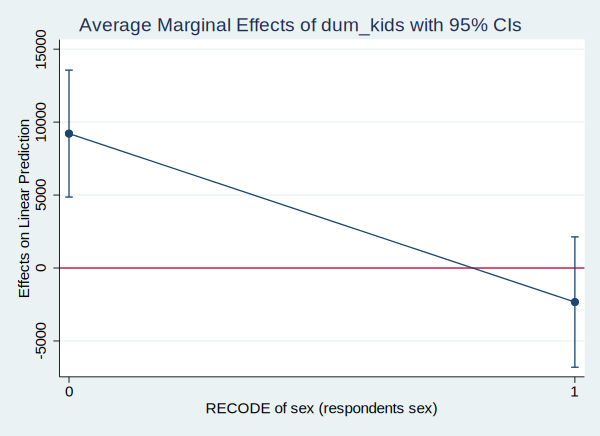

In [52]:
marginsplot, yline(0)

Koefficientens konfidensintervall överlappar inte noll för woman = 0, men gör det för woman = 1. Det betyder som vi såg i tabellen tidigare att det bara är den positiva effekten av att få barn för män som är signifikant; den negativa effekten för kvinnor är det inte.

På motsvarande sätt kan vi ta fram koefficenterna för woman, över de olika värdena på dum_kids. För att marginskommandot ska funka måste man dock ha kört regressionskommandot innan.

In [81]:
margins, dydx(woman) at(dum_kids=(0 1))


Average marginal effects                        Number of obs     =      1,627
Model VCE    : OLS

Expression   : Linear prediction, predict()
dy/dx w.r.t. : 1.woman

1._at        : dum_kids        =           0

2._at        : dum_kids        =           1

------------------------------------------------------------------------------
             |            Delta-method
             |      dy/dx   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
0.woman      |  (base outcome)
-------------+----------------------------------------------------------------
1.woman      |
         _at |
          1  |   -1673.06   2586.229    -0.65   0.518     -6745.76    3399.641
          2  |  -13219.73   1693.765    -7.80   0.000    -16541.93   -9897.537
------------------------------------------------------------------------------
Note: dy/dx for factor levels is the discrete change from the base level.


Kvinnor tjänar mindre än män, oavsett om de har barn eller ej. Men bland de som inte har barn är skillnaden inte signifikant. Det är bara bland de som har barn som könsskillnaden blir påtaglig. Det ser vi också i grafen nedan:


  Variables that uniquely identify margins: dum_kids


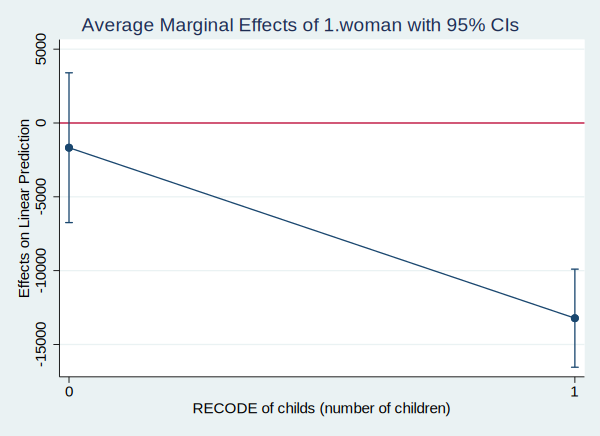

In [82]:
marginsplot, yline(0)

Slutligen kan vi illustrera alltihopa genom att räkna ut predicerade värden, dvs förväntade värden på den beroende variabelm, utifrån siffrorna i tabellerna ovan. Vi gör det med marginskommandot, fast utan dydx-option.

In [83]:
margins, at(dum_kids=(0 1) woman=(0 1))


Predictive margins                              Number of obs     =      1,627
Model VCE    : OLS

Expression   : Linear prediction, predict()

1._at        : woman           =           0
               dum_kids        =           0

2._at        : woman           =           0
               dum_kids        =           1

3._at        : woman           =           1
               dum_kids        =           0

4._at        : woman           =           1
               dum_kids        =           1

------------------------------------------------------------------------------
             |            Delta-method
             |     Margin   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         _at |
          1  |    22425.8   1777.756    12.61   0.000     18938.86    25912.74
          2  |   31638.95   1258.823    25.13   0.000     29169.86    34108.04
          3  |   20752.74   1944.967    10

Här visas nu alltså inte koefficienter, utan gissningar på den beroende variabeln. Koefficienterna symboliserar skillnaderna mellan de olika värdena.

För att verkligen synliggöra slutsatsen kan vi direkt efter marginskommandot skriva __marginsplot:__.


  Variables that uniquely identify margins: dum_kids woman


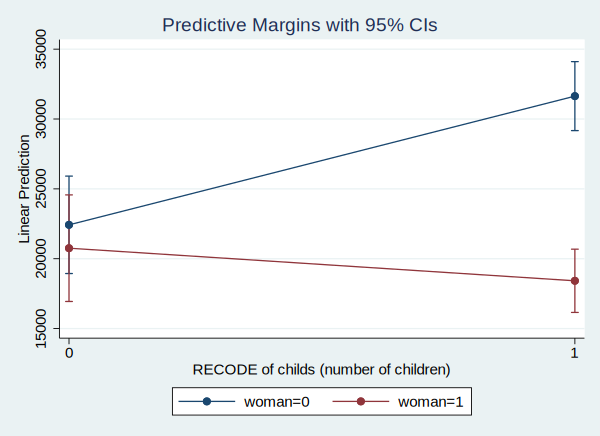

In [84]:
marginsplot

Poängen illustreras här tydligt: Kvinnor och män ligger rätt lika bland dem som inte har barn, men ökar dramatiskt mellan edem som har barn och dem som inte har det.

Alla tre graferna här hänger ihop. De två tidigare, som visade koefficienterna, visar alltså på relationerna mellan de olika punkterna i den sista grafen. Den första, som visade effekten av dum_kids, visar vad som händer när vi går till höger i diagrammet, från noll till ett. Den blåa linjen (männen) går då upp, och den röda linjen (kvinnorna) går ner.

Den andra grafen, som visade effekten av woman, visar vad som händer när vi byter från den blåa till den röda linjen. När vi är på dum_kids = 0 blir det en liten nedgång från den blåa till den röda linjen. När vi är på dum_kids = 1 blir det ett stort hopp ned från den blåa till den röda.

# Avslutning
Slutsatsen av analysen är alltså att könsskillnaderna ser ut att öka kraftigt i samband med barnafödande. Män med barn tjänar mycket mer än män utan barn, medan kvinnor med barn tjänar mindre än kvinnor utan barn. Därför tjänar män utan barn bara lite mer än kvinnor utan barn, medan män med barn tjänar mycket mer än kvinnor med barn.

Annan forskning har visat på rimliga förklaringar till detta; till exempel att barnafödandet leder till att kvinnor i familjer arbetar mindre, och män mer, för att täcka upp. Men det kan vi inte avgöra utifrån den här tvärsnittsanalysen. Här jämför vi bara olika individer med varandra, och det kan finnas mycket som skiljer de olika individerna åt som vi inte tar hänsyn till här.. Men vi har i alla fall kontrollerat för ålder, så skillnaderna beror inte bara på att de som har barn är äldre, till exempel.

Mer allmänt ser vi att viktiga effekter kan döljas när de smetas ut över flera grupper i ett urval: den ursprungliga effekten av barnafödande var svagt positiv. Och många teorier leder till förväntningar på att effekter kommer skilja sig beroende på någon tredje variabels värde. Då är regressionsanalyser med interaktionseffekter viktiga.

Dock blir det lite (men inte mycket) mer komplicerat när en eller båda variabler är kontinuerliga, och har skalor med många värden. Det kommer vi diskutera mer i ett annat inlägg.